# Analytics AADC Experiment

This notebook demonstrates the implementation of Algorithmic Differentiation (AAD) for pricing and risk calculations of Bermudan options. It compares:
- Standard pricing with bump-and-revalue risk calculation
- AAD-based pricing and sensitivity computation

The implementation includes optimal exercise strategy calculation using the Longstaff-Schwartz method.

In [1]:
import inspect
import analytics
import analytics_aadc
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import numpy as np
import copy
from contract import Contract, Cashflow, Leg, Option
from observable import Observable, Ticker, Observation
from market import pricing_time_steps
from time import time

## Pricing Function Definition

Define a function that computes both standard and AAD-based prices and sensitivities. The function:
1. Solves for optimal exercise strategy
2. Computes prices using both methods
3. Calculates delta using bump-and-revalue

In [2]:
def price_normal_and_aadc(bermudan):
    res = {}
    auto_trade = analytics.solve_callable_contract(bermudan, market_t0, model)    

    # AAD price calculation
    price_aadc = analytics_aadc.price_mc_trade_aadc(auto_trade, market_t0, model)
    res["aadc"] = price_aadc

    # Standard price calculation
    price_base = analytics.price_mc_trade(auto_trade, market_t0, model)
    res["price"] = price_base

    # Bump and revalue risk calculation
    # Here we solve for optimal exercise strategy and price the contract for each market bump
    h = 0.1
    bumped_market = copy.deepcopy(market_t0)
    
    # Up bump
    bumped_market.indexes["SPX"] += h
    auto_trade = analytics.solve_callable_contract(bermudan, bumped_market, model)    
    price_bumped_up = analytics.price_mc_trade(auto_trade, bumped_market, model)
    
    # Down bump
    bumped_market.indexes["SPX"] -= 2.0 * h
    auto_trade = analytics.solve_callable_contract(bermudan, bumped_market, model)    
    price_bumped_down = analytics.price_mc_trade(auto_trade, bumped_market, model)

    # Calculate delta using central difference
    res["delta"] = (price_bumped_up - price_bumped_down) / (2.0 * h)

    return res

## Market Setup

Initialize market parameters including index values and volatilities.

In [3]:
ticker = Ticker("SPX", "INDEX")
strike = 100.0
ccy = "USD"
notional = 1_000_000

today = datetime(2024, 7, 11)

# Initial market setup
index_values = {"SPX": 100.0, "USD": 1.0, "EUR": 1.2}
market_t0 = analytics.Market(index_values, today)

pricing_time_steps = pricing_time_steps(market_t0)

# Volatility setup - note higher SPX vol of 0.15
vols = {"SPX": 0.15, "USD": 0.1, "EUR": 0.1}
model = analytics.Model(vols, pricing_time_steps)

## Bermudan Option Definition

Create a Bermudan option with two exercise dates and apply Longstaff-Schwartz transformation for optimal exercise strategy.

In [4]:
# Define exercise dates
first_exercise = datetime(2025, 1, 1)   # 1Y
second_exercise = datetime(2026, 1, 1)  # 2Y

strike = 100.0
spx = Ticker("SPX", "INDEX")

# Build nested option structure
bermudan = Option(
    Observation(Ticker("Call", "CPTY"), first_exercise),  # First exercise decision
    Option(                                               # If not exercised at first date
        Observation(Ticker("Call", "CPTY"), second_exercise),  # Second exercise decision
        Cashflow(Observation(spx, second_exercise) - strike, second_exercise, "USD", 1.0),  # Exercise at 2Y
        None                                                                                # Expire worthless
    ),
    Cashflow(Observation(spx, first_exercise) - strike, first_exercise, "USD", 1.0)  # Exercise at 1Y
)

print("Original Bermudan option structure:")
print(bermudan)

# Transform using Longstaff-Schwartz (requires model)
transformed = analytics.solve_callable_contract(bermudan, market_t0, model)

print("\nTransformed option structure:")
print(transformed)

Original Bermudan option structure:
if Call(2025-01-01) is positive then
    if Call(2026-01-01) is positive then
        (SPX(2026-01-01) - 100.0)	1.0	USD	2026-01-01
    else
        None
else
    (SPX(2025-01-01) - 100.0)	1.0	USD	2025-01-01

Transformed option structure:
if ((BASIS2_SPX(2025-01-01) * 0.010613335737635088) + ((EUR(2025-01-01) * -0.5487011161843771) + ((SPX(2025-01-01) * -2.6084913188160126) + 161.51593106772089))) is positive then
    if ((SPX(2026-01-01) * 1.0000000000000004) + -99.99999999999993) is positive then
        (SPX(2026-01-01) - 100.0)	1.0	USD	2026-01-01
    else
        None
else
    (SPX(2025-01-01) - 100.0)	1.0	USD	2025-01-01


## Price and Risk Analysis

Compute prices and sensitivities across a range of spot prices to compare base and AAD methods.

In [5]:
plot_data = {"base": {"price": [], "delta": []}, "aadc": {"price": [], "delta": []}}

for i in range(120):
    market_t0.indexes["SPX"] = 50.0 + i

    res = price_normal_and_aadc(bermudan)
    print(f"Spot: {50.0 + i:.1f}, Base Price: {res['price']:.4f}, AAD Price: {res['aadc']['price']:.4f}, "
          f"Base Delta: {res['delta']:.4f}, AAD Delta: {res['aadc']['delta']:.4f}")

    plot_data["base"]["price"].append(res["price"])
    plot_data["base"]["delta"].append(res["delta"])
    plot_data["aadc"]["price"].append(res["aadc"]["price"])
    plot_data["aadc"]["delta"].append(res["aadc"]["delta"])

Number active to passive conversions: 0 while recording Python
Spot: 50.0, Base Price: 0.0001, AAD Price: 0.0001, Base Delta: 0.0001, AAD Delta: 0.0001
Number active to passive conversions: 0 while recording Python
Spot: 51.0, Base Price: 0.0003, AAD Price: 0.0003, Base Delta: 0.0003, AAD Delta: 0.0003
Number active to passive conversions: 0 while recording Python
Spot: 52.0, Base Price: 0.0007, AAD Price: 0.0007, Base Delta: 0.0004, AAD Delta: 0.0004
Number active to passive conversions: 0 while recording Python
Spot: 53.0, Base Price: 0.0012, AAD Price: 0.0012, Base Delta: 0.0006, AAD Delta: 0.0006
Number active to passive conversions: 0 while recording Python
Spot: 54.0, Base Price: 0.0018, AAD Price: 0.0018, Base Delta: 0.0008, AAD Delta: 0.0008
Number active to passive conversions: 0 while recording Python
Spot: 55.0, Base Price: 0.0026, AAD Price: 0.0026, Base Delta: 0.0009, AAD Delta: 0.0009
Number active to passive conversions: 0 while recording Python
Spot: 56.0, Base Price: 0

## Results Visualization

Plot the comparison between base and AAD calculations for both price and delta.

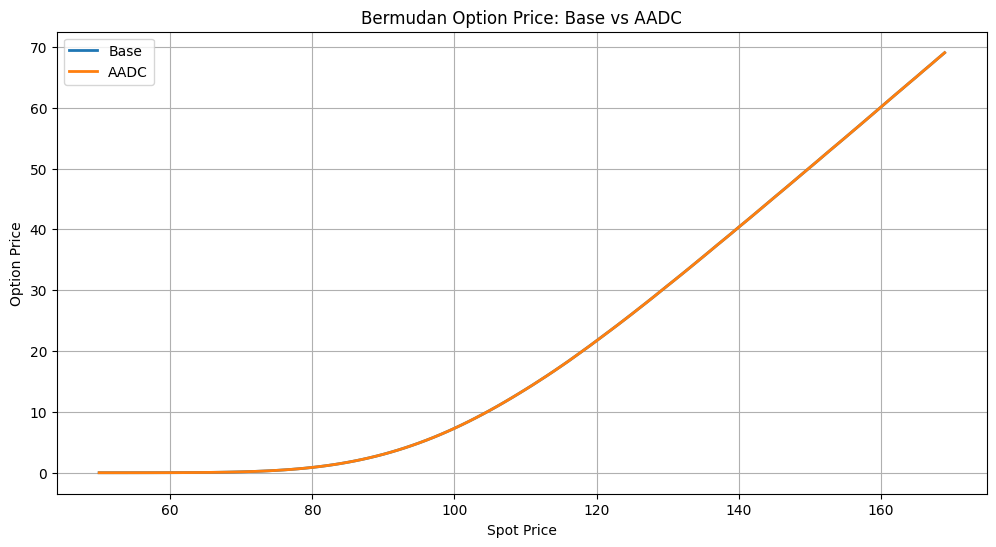

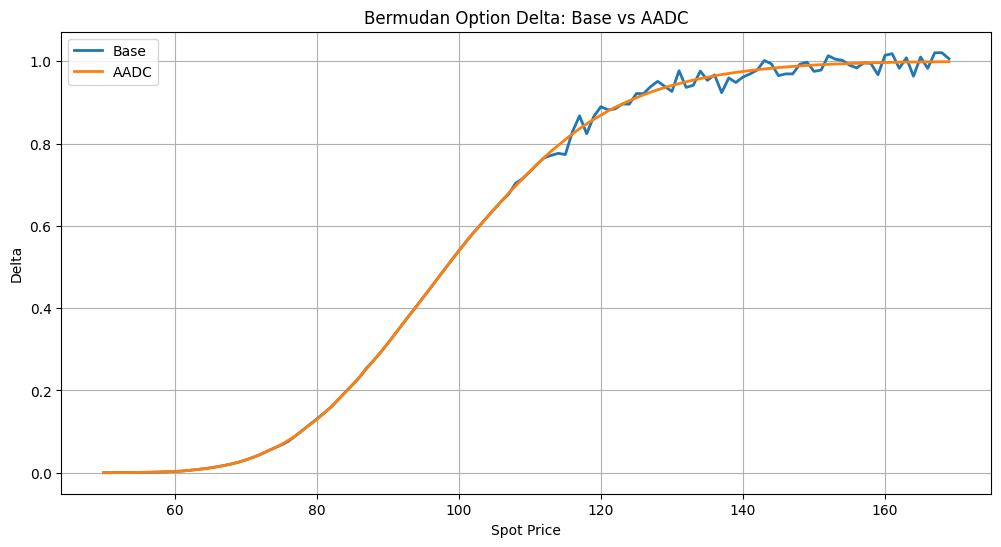

In [7]:
# Price comparison plot
plt.figure(figsize=(12, 6))
plt.plot(range(50, 170), plot_data["base"]["price"], label="Base", linewidth=2)
plt.plot(range(50, 170), plot_data["aadc"]["price"], label="AADC", linewidth=2)
plt.title("Bermudan Option Price: Base vs AADC")
plt.xlabel("Spot Price")
plt.ylabel("Option Price")
plt.grid(True)
plt.legend()
plt.show()

# Delta comparison plot
plt.figure(figsize=(12, 6))
plt.plot(range(50, 170), plot_data["base"]["delta"], label="Base", linewidth=2)
plt.plot(range(50, 170), plot_data["aadc"]["delta"], label="AADC", linewidth=2)
plt.title("Bermudan Option Delta: Base vs AADC")
plt.xlabel("Spot Price")
plt.ylabel("Delta")
plt.grid(True)
plt.legend()
plt.show()